In [8]:
# Install required packages (run this cell first)
%pip install --quiet yfinance pandas numpy matplotlib seaborn plotly
print("✓ All packages installed successfully!")


Note: you may need to restart the kernel to use updated packages.
✓ All packages installed successfully!


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [10]:
# Dot-com bubble era companies (representative sample)
dotcom_companies = {
    'CSCO': 'Cisco Systems',
    'INTC': 'Intel',
    'MSFT': 'Microsoft',
    'ORCL': 'Oracle',
    'AMZN': 'Amazon',
    'YHOO': 'Yahoo!',
    'EBAY': 'eBay',
    'DELL': 'Dell',
    'JDSU': 'JDS Uniphase',  # Classic bubble stock
    'T': 'AT&T'
}

# Current AI bubble companies
ai_companies = {
    'NVDA': 'NVIDIA',
    'MSFT': 'Microsoft',
    'AAPL': 'Apple',
    'GOOGL': 'Alphabet',
    'META': 'Meta',
    'AMD': 'AMD',
    'TSLA': 'Tesla',
    'PLTR': 'Palantir',
    'SMCI': 'Super Micro Computer',
    'AVGO': 'Broadcom'
}

print("Dot-com Era Companies:", list(dotcom_companies.values()))
print("\nAI Era Companies:", list(ai_companies.values()))


Dot-com Era Companies: ['Cisco Systems', 'Intel', 'Microsoft', 'Oracle', 'Amazon', 'Yahoo!', 'eBay', 'Dell', 'JDS Uniphase', 'AT&T']

AI Era Companies: ['NVIDIA', 'Microsoft', 'Apple', 'Alphabet', 'Meta', 'AMD', 'Tesla', 'Palantir', 'Super Micro Computer', 'Broadcom']


In [11]:
# Dot-com bubble period: 1998-2002 (peak around March 2000)
start_date_dotcom = '1998-01-01'
end_date_dotcom = '2002-12-31'

dotcom_data = {}
print("Fetching Dot-com Era Data...")
for ticker, name in dotcom_companies.items():
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date_dotcom, end=end_date_dotcom)
        if not hist.empty:
            dotcom_data[ticker] = hist
            print(f"✓ {name} ({ticker}) - {len(hist)} days of data")
        else:
            print(f"✗ {name} ({ticker}) - No data available")
    except Exception as e:
        print(f"✗ {name} ({ticker}) - Error: {str(e)}")

print(f"\nSuccessfully fetched data for {len(dotcom_data)} companies")


Fetching Dot-com Era Data...
✓ Cisco Systems (CSCO) - 1255 days of data
✓ Intel (INTC) - 1255 days of data
✓ Microsoft (MSFT) - 1255 days of data
✓ Oracle (ORCL) - 1255 days of data
✓ Amazon (AMZN) - 1255 days of data


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: YHOO"}}}
$YHOO: possibly delisted; no timezone found


✗ Yahoo! (YHOO) - No data available
✓ eBay (EBAY) - 1072 days of data


$DELL: possibly delisted; no price data found  (1d 1998-01-01 -> 2002-12-31) (Yahoo error = "Data doesn't exist for startDate = 883630800, endDate = 1041310800")
$JDSU: possibly delisted; no price data found  (1d 1998-01-01 -> 2002-12-31)


✗ Dell (DELL) - No data available
✗ JDS Uniphase (JDSU) - No data available
✓ AT&T (T) - 1255 days of data

Successfully fetched data for 7 companies


In [12]:
# AI bubble period: 2022-2024 (current)
start_date_ai = '2022-01-01'
end_date_ai = datetime.now().strftime('%Y-%m-%d')

ai_data = {}
print("Fetching AI Era Data...")
for ticker, name in ai_companies.items():
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date_ai, end=end_date_ai)
        if not hist.empty:
            ai_data[ticker] = hist
            print(f"✓ {name} ({ticker}) - {len(hist)} days of data")
        else:
            print(f"✗ {name} ({ticker}) - No data available")
    except Exception as e:
        print(f"✗ {name} ({ticker}) - Error: {str(e)}")

print(f"\nSuccessfully fetched data for {len(ai_data)} companies")


Fetching AI Era Data...
✓ NVIDIA (NVDA) - 973 days of data
✓ Microsoft (MSFT) - 973 days of data
✓ Apple (AAPL) - 973 days of data
✓ Alphabet (GOOGL) - 973 days of data
✓ Meta (META) - 973 days of data
✓ AMD (AMD) - 973 days of data
✓ Tesla (TSLA) - 973 days of data
✓ Palantir (PLTR) - 973 days of data
✓ Super Micro Computer (SMCI) - 973 days of data
✓ Broadcom (AVGO) - 973 days of data

Successfully fetched data for 10 companies


In [13]:
def calculate_metrics(data_dict, period_name):
    """Calculate key financial metrics for a period"""
    metrics = []
    
    for ticker, hist in data_dict.items():
        if hist.empty:
            continue
            
        # Normalize prices to base 100 for comparison
        hist['Normalized_Price'] = (hist['Close'] / hist['Close'].iloc[0]) * 100
        
        # Calculate returns
        hist['Daily_Return'] = hist['Close'].pct_change()
        hist['Cumulative_Return'] = (1 + hist['Daily_Return']).cumprod() - 1
        
        # Volatility (annualized)
        volatility = hist['Daily_Return'].std() * np.sqrt(252)
        
        # Maximum drawdown
        cumulative = (1 + hist['Daily_Return']).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Peak date
        peak_price = hist['Normalized_Price'].max()
        peak_date = hist[hist['Normalized_Price'] == peak_price].index[0]
        
        # Total return
        total_return = ((hist['Close'].iloc[-1] / hist['Close'].iloc[0]) - 1) * 100
        
        # Get current market cap and P/E if available
        try:
            info = yf.Ticker(ticker).info
            market_cap = info.get('marketCap', None)
            pe_ratio = info.get('trailingPE', None)
        except:
            market_cap = None
            pe_ratio = None
        
        metrics.append({
            'Ticker': ticker,
            'Period': period_name,
            'Total_Return_%': total_return,
            'Volatility': volatility * 100,
            'Max_Drawdown_%': max_drawdown * 100,
            'Peak_Date': peak_date,
            'Peak_Price_Normalized': peak_price,
            'Market_Cap': market_cap,
            'PE_Ratio': pe_ratio,
            'Price_Data': hist
        })
    
    return pd.DataFrame(metrics)

# Calculate metrics for both periods
dotcom_metrics = calculate_metrics(dotcom_data, 'Dot-com Era')
ai_metrics = calculate_metrics(ai_data, 'AI Era')

print("Dot-com Era Metrics:")
print(dotcom_metrics[['Ticker', 'Total_Return_%', 'Volatility', 'Max_Drawdown_%']].round(2))
print("\nAI Era Metrics:")
print(ai_metrics[['Ticker', 'Total_Return_%', 'Volatility', 'Max_Drawdown_%']].round(2))


Dot-com Era Metrics:
  Ticker  Total_Return_%  Volatility  Max_Drawdown_%
0   CSCO           34.03       62.46          -89.26
1   INTC          -12.26       57.78          -82.25
2   MSFT           60.92       44.46          -65.16
3   ORCL          185.39       71.11          -84.19
4   AMZN          288.23       98.25          -94.40
5   EBAY          758.43       96.85          -77.08
6      T          -14.66       38.46          -63.53

AI Era Metrics:
  Ticker  Total_Return_%  Volatility  Max_Drawdown_%
0   NVDA          520.67       54.44          -61.64
1   MSFT           56.39       26.97          -34.45
2   AAPL           50.03       28.87          -33.36
3  GOOGL           97.93       32.74          -43.63
4   META           78.92       46.79          -73.58
5    AMD           60.09       54.80          -63.00
6   TSLA            2.25       62.40          -71.79
7   PLTR          824.18       69.28          -66.98
8   SMCI          647.48       90.01          -84.84
9   AVGO

Comparative Statistics:
            Total_Return_%                Volatility                \
                      mean median     std       mean median    std   
Period                                                               
AI Era              279.45  88.43  302.26      51.10  50.61  19.64   
Dot-com Era         185.73  60.92  275.81      67.05  62.46  23.50   

            Max_Drawdown_%                
                      mean median    std  
Period                                    
AI Era              -57.44 -62.32  18.02  
Dot-com Era         -79.41 -82.25  11.64  


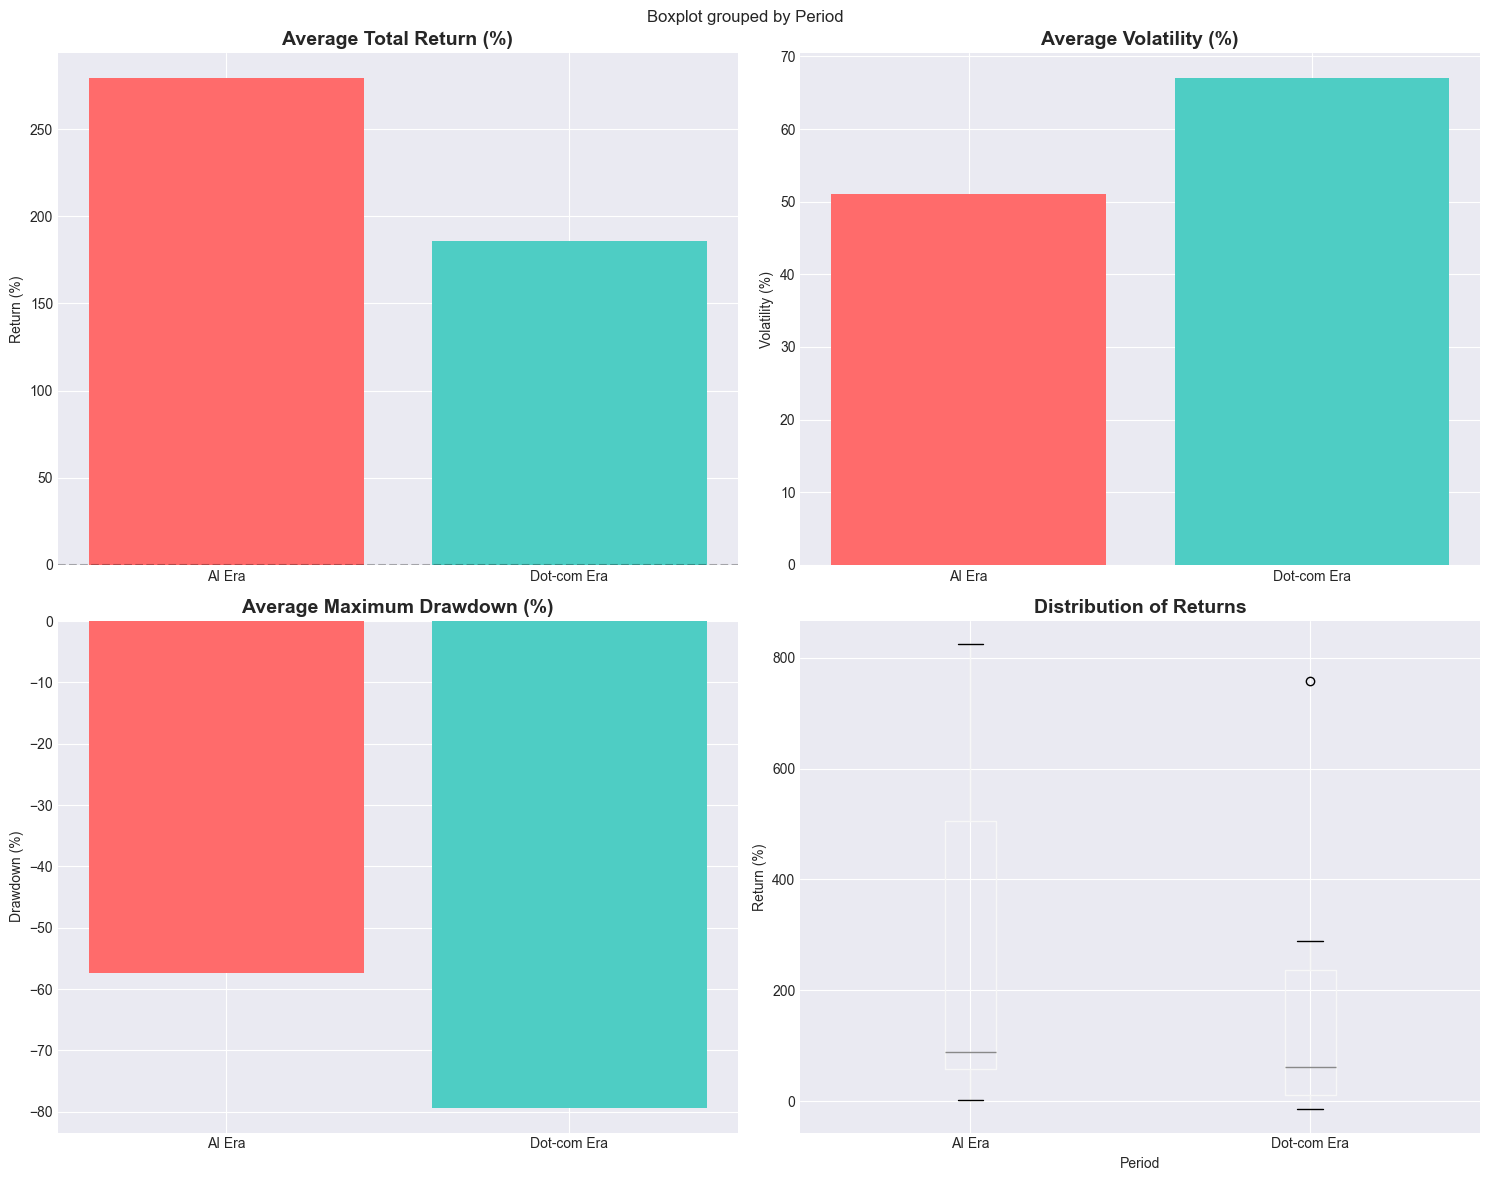

In [14]:
# Combine metrics for comparison
all_metrics = pd.concat([dotcom_metrics, ai_metrics], ignore_index=True)

# Statistical comparison
comparison = all_metrics.groupby('Period').agg({
    'Total_Return_%': ['mean', 'median', 'std'],
    'Volatility': ['mean', 'median', 'std'],
    'Max_Drawdown_%': ['mean', 'median', 'std']
}).round(2)

print("Comparative Statistics:")
print(comparison)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average Returns Comparison
period_means = all_metrics.groupby('Period')['Total_Return_%'].mean()
axes[0, 0].bar(period_means.index, period_means.values, color=['#FF6B6B', '#4ECDC4'])
axes[0, 0].set_title('Average Total Return (%)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)

# 2. Volatility Comparison
vol_means = all_metrics.groupby('Period')['Volatility'].mean()
axes[0, 1].bar(vol_means.index, vol_means.values, color=['#FF6B6B', '#4ECDC4'])
axes[0, 1].set_title('Average Volatility (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Volatility (%)')

# 3. Maximum Drawdown Comparison
dd_means = all_metrics.groupby('Period')['Max_Drawdown_%'].mean()
axes[1, 0].bar(dd_means.index, dd_means.values, color=['#FF6B6B', '#4ECDC4'])
axes[1, 0].set_title('Average Maximum Drawdown (%)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Drawdown (%)')

# 4. Box plot of Returns
all_metrics.boxplot(column='Total_Return_%', by='Period', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Returns', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Period')
axes[1, 1].set_ylabel('Return (%)')

plt.tight_layout()
plt.show()


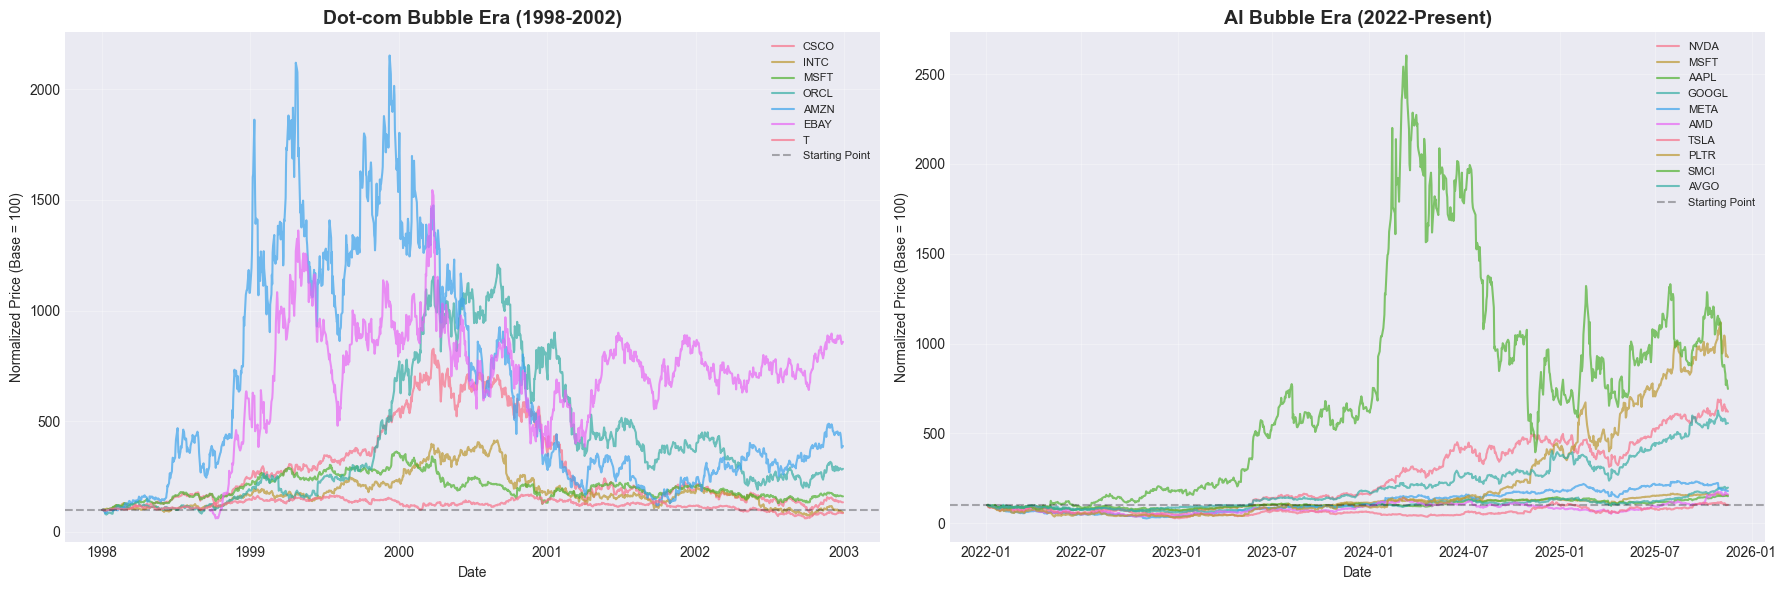

In [15]:
# Normalize all prices and compare trajectories
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Dot-com era trajectories
axes[0].set_title('Dot-com Bubble Era (1998-2002)', fontsize=14, fontweight='bold')
for ticker, hist in dotcom_data.items():
    normalized = (hist['Close'] / hist['Close'].iloc[0]) * 100
    axes[0].plot(hist.index, normalized, label=ticker, alpha=0.7, linewidth=1.5)
axes[0].axhline(y=100, color='black', linestyle='--', alpha=0.3, label='Starting Point')
axes[0].set_ylabel('Normalized Price (Base = 100)')
axes[0].set_xlabel('Date')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

# AI era trajectories
axes[1].set_title('AI Bubble Era (2022-Present)', fontsize=14, fontweight='bold')
for ticker, hist in ai_data.items():
    normalized = (hist['Close'] / hist['Close'].iloc[0]) * 100
    axes[1].plot(hist.index, normalized, label=ticker, alpha=0.7, linewidth=1.5)
axes[1].axhline(y=100, color='black', linestyle='--', alpha=0.3, label='Starting Point')
axes[1].set_ylabel('Normalized Price (Base = 100)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Current AI Company Metrics:
  Ticker  Market_Cap_Billions  PE_Ratio  Price_To_Sales
0   NVDA              4422.93     53.18           26.77
1   MSFT              3670.42     36.10           12.49
2   AAPL              3968.91     35.85            9.54
3  GOOGL              3443.23     28.09            8.93
4   META              1506.49     26.47            7.95
5    AMD               374.92    126.53           11.71
6   TSLA              1334.48    280.59           13.95
7   PLTR               398.82   1673.30          102.36
8   SMCI                20.83     26.85            0.99
9   AVGO              1607.97     87.08           26.83


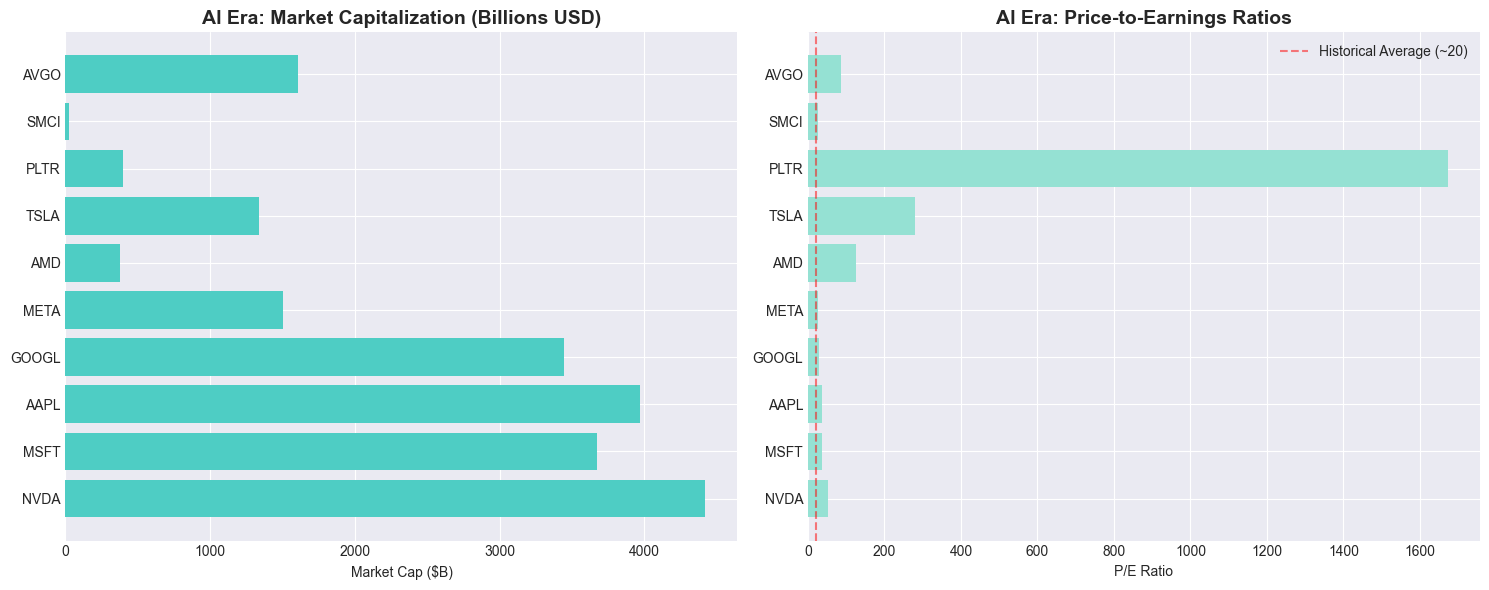

In [16]:
# Fetch current market caps and P/E ratios
def get_current_metrics(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'Ticker': ticker,
            'Market_Cap_Billions': info.get('marketCap', 0) / 1e9,
            'PE_Ratio': info.get('trailingPE', None),
            'Forward_PE': info.get('forwardPE', None),
            'Price_To_Sales': info.get('priceToSalesTrailing12Months', None),
            'Enterprise_Value_Billions': info.get('enterpriseValue', 0) / 1e9
        }
    except:
        return {
            'Ticker': ticker,
            'Market_Cap_Billions': None,
            'PE_Ratio': None,
            'Forward_PE': None,
            'Price_To_Sales': None,
            'Enterprise_Value_Billions': None
        }

# Get current metrics for AI companies
ai_current_metrics = pd.DataFrame([get_current_metrics(ticker) for ticker in ai_companies.keys()])
ai_current_metrics['Period'] = 'AI Era'

print("Current AI Company Metrics:")
print(ai_current_metrics[['Ticker', 'Market_Cap_Billions', 'PE_Ratio', 'Price_To_Sales']].round(2))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Market Cap Comparison
axes[0].barh(ai_current_metrics['Ticker'], ai_current_metrics['Market_Cap_Billions'], color='#4ECDC4')
axes[0].set_title('AI Era: Market Capitalization (Billions USD)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Market Cap ($B)')

# P/E Ratio (where available)
pe_data = ai_current_metrics[ai_current_metrics['PE_Ratio'].notna()]
axes[1].barh(pe_data['Ticker'], pe_data['PE_Ratio'], color='#95E1D3')
axes[1].set_title('AI Era: Price-to-Earnings Ratios', fontsize=14, fontweight='bold')
axes[1].set_xlabel('P/E Ratio')
axes[1].axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Historical Average (~20)')
axes[1].legend()

plt.tight_layout()
plt.show()


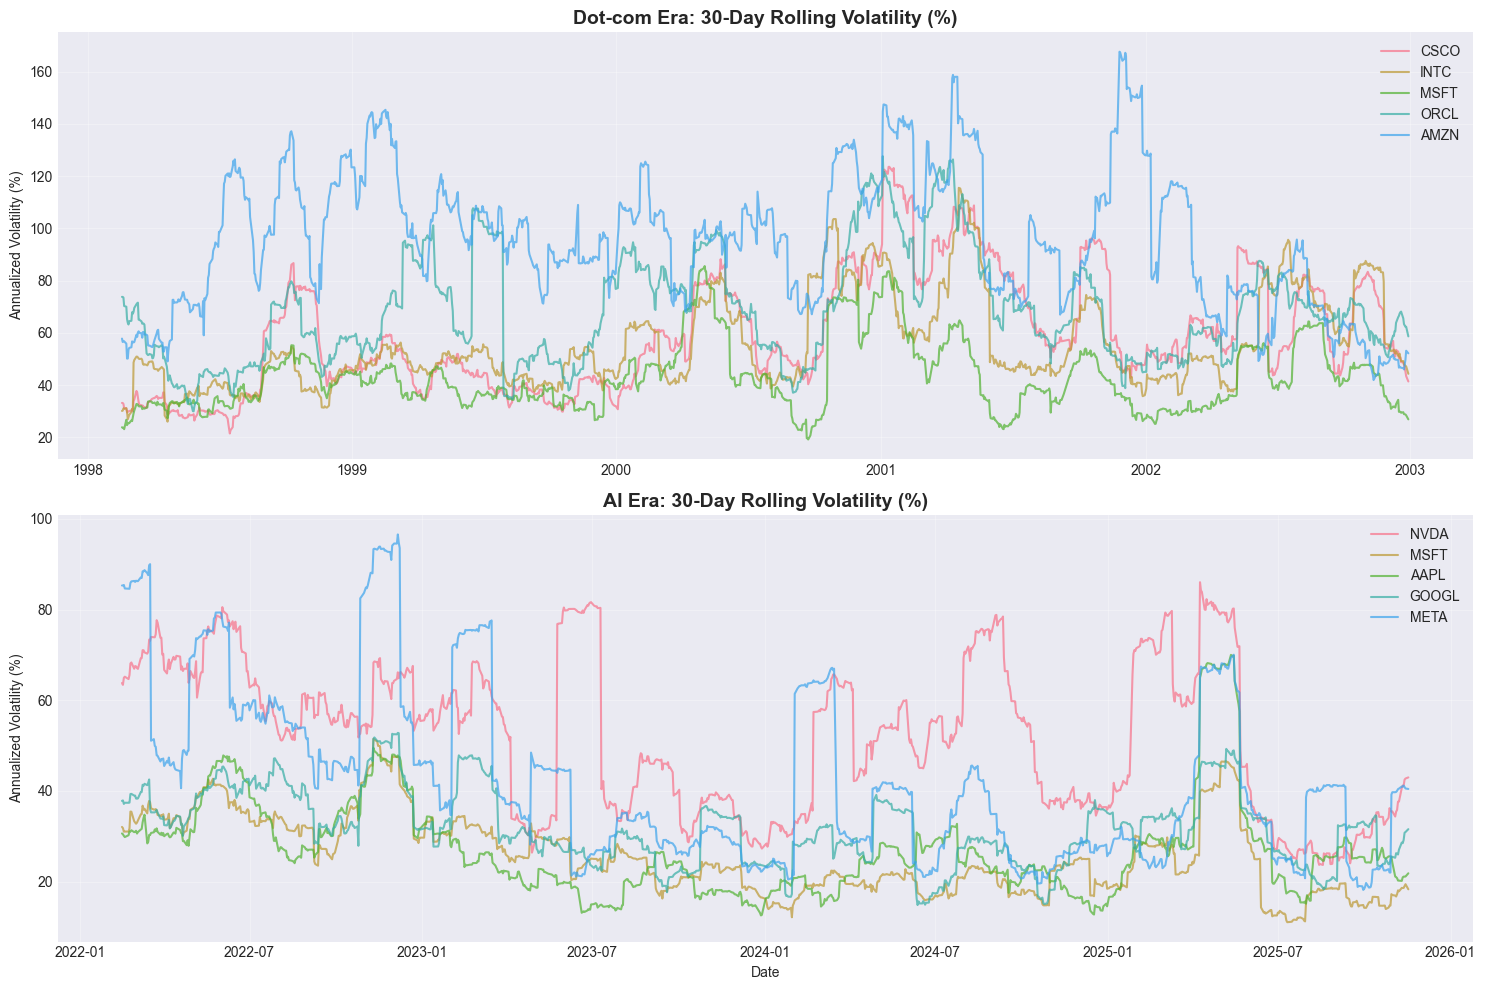

In [17]:
# Calculate rolling volatility for comparison
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Dot-com era rolling volatility (30-day)
for ticker, hist in list(dotcom_data.items())[:5]:  # Show top 5
    hist['Rolling_Vol'] = hist['Close'].pct_change().rolling(30).std() * np.sqrt(252) * 100
    axes[0].plot(hist.index, hist['Rolling_Vol'], label=ticker, alpha=0.7, linewidth=1.5)
axes[0].set_title('Dot-com Era: 30-Day Rolling Volatility (%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Annualized Volatility (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AI era rolling volatility
for ticker, hist in list(ai_data.items())[:5]:  # Show top 5
    hist['Rolling_Vol'] = hist['Close'].pct_change().rolling(30).std() * np.sqrt(252) * 100
    axes[1].plot(hist.index, hist['Rolling_Vol'], label=ticker, alpha=0.7, linewidth=1.5)
axes[1].set_title('AI Era: 30-Day Rolling Volatility (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Annualized Volatility (%)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# Create a comprehensive comparison table
print("=" * 80)
print("BUBBLE COMPARISON: DOT-COM vs AI ERA")
print("=" * 80)

print("\n1. PERFORMANCE METRICS:")
print("-" * 80)
summary_stats = all_metrics.groupby('Period').agg({
    'Total_Return_%': ['mean', 'std', 'min', 'max'],
    'Volatility': ['mean'],
    'Max_Drawdown_%': ['mean']
}).round(2)
print(summary_stats)

print("\n2. KEY DIFFERENCES:")
print("-" * 80)
dotcom_avg_return = dotcom_metrics['Total_Return_%'].mean()
ai_avg_return = ai_metrics['Total_Return_%'].mean()
dotcom_avg_vol = dotcom_metrics['Volatility'].mean()
ai_avg_vol = ai_metrics['Volatility'].mean()

print(f"Average Return: Dot-com = {dotcom_avg_return:.2f}%, AI = {ai_avg_return:.2f}%")
print(f"Average Volatility: Dot-com = {dotcom_avg_vol:.2f}%, AI = {ai_avg_vol:.2f}%")
print(f"Return Difference: {ai_avg_return - dotcom_avg_return:.2f} percentage points")
print(f"Volatility Difference: {ai_avg_vol - dotcom_avg_vol:.2f} percentage points")

print("\n3. CURRENT AI COMPANY VALUATIONS:")
print("-" * 80)
print(ai_current_metrics[['Ticker', 'Market_Cap_Billions', 'PE_Ratio', 'Price_To_Sales']].to_string(index=False))

print("\n" + "=" * 80)


BUBBLE COMPARISON: DOT-COM vs AI ERA

1. PERFORMANCE METRICS:
--------------------------------------------------------------------------------
            Total_Return_%                        Volatility Max_Drawdown_%
                      mean     std    min     max       mean           mean
Period                                                                     
AI Era              279.45  302.26   2.25  824.18      51.10         -57.44
Dot-com Era         185.73  275.81 -14.66  758.43      67.05         -79.41

2. KEY DIFFERENCES:
--------------------------------------------------------------------------------
Average Return: Dot-com = 185.73%, AI = 279.45%
Average Volatility: Dot-com = 67.05%, AI = 51.10%
Return Difference: 93.73 percentage points
Volatility Difference: -15.95 percentage points

3. CURRENT AI COMPANY VALUATIONS:
--------------------------------------------------------------------------------
Ticker  Market_Cap_Billions    PE_Ratio  Price_To_Sales
  NVDA        